In [2]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1dc274c5-54d4-d395-7915-5293813a72c4)


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
np.random.seed(123)
tf.random.set_seed(456)
rn.seed(789)

# **Load Data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#0 = Lady_Finger_Banana, 1 = Cavendish_Banana, 2 = Cultivated_Banana

x0 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Lady_Finger_Banana.npy')
x1 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cavendish_Banana.npy')
x2 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cultivated_Banana.npy')

print(x0.shape)
print(x1.shape)
print(x2.shape)

(200, 224, 224, 3)
(200, 224, 224, 3)
(200, 224, 224, 3)


In [7]:
y0 = np.array([0 for i in range(200)])
y1 = np.array([1 for i in range(200)])
y2 = np.array([2 for i in range(200)])

print(y0.shape)
print(y1.shape)
print(y2.shape)

(200,)
(200,)
(200,)


In [8]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(600, 224, 224, 3)
(600,)


In [9]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(420, 224, 224, 3)
(420,)
(180, 224, 224, 3)
(180,)


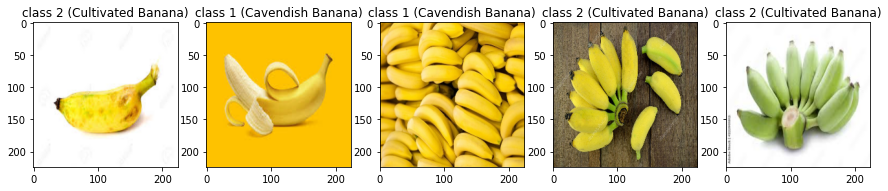

In [10]:
# #visualize the first 5 image of train set
label = ['Lady Finger Banana','Cavendish Banana','Cultivated Banana']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

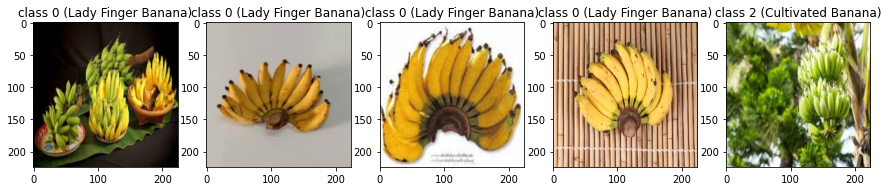

In [11]:
# #visualize the first 5 image of test set
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

# **Select Pre-Trained Model**

In [12]:
#Load ResNet50V2 model

rn_extractor = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
rn_extractor.summary()

94668760/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [13]:
#Pre-processing
x_train_rn = tf.keras.applications.resnet_v2.preprocess_input(x_train)
x_test_rn = tf.keras.applications.resnet_v2.preprocess_input(x_test)

print(x_train_rn.shape)
print(x_test_rn.shape)

(420, 224, 224, 3)
(180, 224, 224, 3)


In [14]:
# tf.keras.utils.plot_model(rn_extractor, to_file = 'rn_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 150)

In [16]:
#Recursively freeze all layers in the model first
rn_extractor.trainable = False

for i, layer in enumerate(rn_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = conv1_pad, Trainable = False
Layer 2: Name = conv1_conv, Trainable = False
Layer 3: Name = pool1_pad, Trainable = False
Layer 4: Name = pool1_pool, Trainable = False
Layer 5: Name = conv2_block1_preact_bn, Trainable = False
Layer 6: Name = conv2_block1_preact_relu, Trainable = False
Layer 7: Name = conv2_block1_1_conv, Trainable = False
Layer 8: Name = conv2_block1_1_bn, Trainable = False
Layer 9: Name = conv2_block1_1_relu, Trainable = False
Layer 10: Name = conv2_block1_2_pad, Trainable = False
Layer 11: Name = conv2_block1_2_conv, Trainable = False
Layer 12: Name = conv2_block1_2_bn, Trainable = False
Layer 13: Name = conv2_block1_2_relu, Trainable = False
Layer 14: Name = conv2_block1_0_conv, Trainable = False
Layer 15: Name = conv2_block1_3_conv, Trainable = False
Layer 16: Name = conv2_block1_out, Trainable = False
Layer 17: Name = conv2_block2_preact_bn, Trainable = False
Layer 18: Name = conv2_block2_preact_relu, Traina

# **Data Augmentation**

In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,             
        samplewise_center=True,             
        #featurewise_std_normalization=True,  
        samplewise_std_normalization=True,   
        #zca_whitening=False,                  
        rotation_range=0,                     
        width_shift_range=5.0,                
        height_shift_range=5.0,               
        zoom_range=0.2,
        horizontal_flip=True,                 
        vertical_flip=True,
        validation_split=0.3)

train_datagen.fit(x_train_rn, seed = 123)

In [18]:
print(x_train_rn.shape)

(420, 224, 224, 3)


In [19]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # rescale=1. / 255,
        featurewise_center=True,             
        # samplewise_center=True,             
        featurewise_std_normalization=True,  
        # samplewise_std_normalization=True
        )

test_datagen.fit(x_test_rn, seed = 123)

===== Train batch no. 1/1 =====


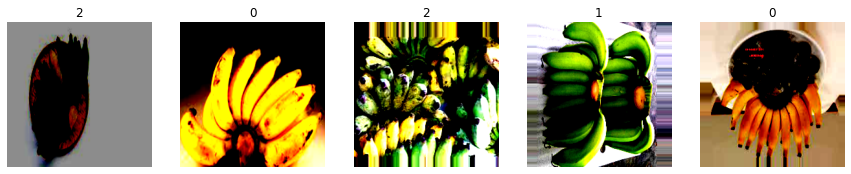

In [20]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train_rn, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


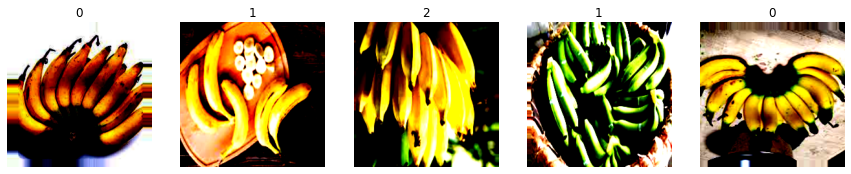

In [21]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train_rn, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

In [22]:
# n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

# for b, (x_batch, y_batch) in enumerate( test_datagen.flow( x_test_rn,y_test,batch_size=5 ) ):
#   print( f"===== Train batch no. {b+1}/{n_show} =====" )
#   plt.figure(figsize=(15,5))
#   for i in range(5):
#       plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
#       plt.imshow( x_batch[i])
#       plt.axis( "off" )        # remove all tick marks 
#   plt.show()

#   if b+1 >= n_show:
#     break

# **Train & Model Evaluate**

In [23]:
x = rn_extractor.output

#Add our custom layer(s) to the end of the existing model

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

new_outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

#construct the main model

model = tf.keras.models.Model(inputs = rn_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
# tf.keras.utils.plot_model(model, to_file = 'rn_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 150)

In [25]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc'] 
                     )

In [26]:
checkpoint_filepath = "bestweights.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

In [28]:
ep = 30

history = model.fit(train_datagen.flow(x_train_rn ,y_train,batch_size=128,subset='training',seed = 123),epochs = ep, verbose = 2,
                    callbacks=[model_checkpoint_callback],
                    validation_data=train_datagen.flow(x_train_rn ,y_train,subset='validation',seed=123))

Epoch 1/30
3/3 - 22s - loss: 12.9974 - acc: 0.3639 - val_loss: 3.1797 - val_acc: 0.5714 - 22s/epoch - 7s/step
Epoch 2/30
3/3 - 6s - loss: 7.7681 - acc: 0.4966 - val_loss: 3.7481 - val_acc: 0.6508 - 6s/epoch - 2s/step
Epoch 3/30
3/3 - 5s - loss: 6.0797 - acc: 0.5510 - val_loss: 3.2027 - val_acc: 0.5556 - 5s/epoch - 2s/step
Epoch 4/30
3/3 - 6s - loss: 5.1680 - acc: 0.5170 - val_loss: 1.3202 - val_acc: 0.7302 - 6s/epoch - 2s/step
Epoch 5/30
3/3 - 6s - loss: 3.8278 - acc: 0.5408 - val_loss: 1.8398 - val_acc: 0.7381 - 6s/epoch - 2s/step
Epoch 6/30
3/3 - 6s - loss: 3.0480 - acc: 0.6429 - val_loss: 1.3950 - val_acc: 0.7540 - 6s/epoch - 2s/step
Epoch 7/30
3/3 - 5s - loss: 3.4549 - acc: 0.6327 - val_loss: 1.5238 - val_acc: 0.7381 - 5s/epoch - 2s/step
Epoch 8/30
3/3 - 6s - loss: 2.6925 - acc: 0.6020 - val_loss: 0.9091 - val_acc: 0.8016 - 6s/epoch - 2s/step
Epoch 9/30
3/3 - 5s - loss: 1.9055 - acc: 0.5986 - val_loss: 1.0441 - val_acc: 0.7778 - 5s/epoch - 2s/step
Epoch 10/30
3/3 - 5s - loss: 1.454

In [29]:
model.load_weights("bestweights.hdf5")
results = model.evaluate(test_datagen.flow(x_test_rn, y_test, batch_size = 128, seed = 123, shuffle = False))
print(f'{model.metrics_names}: {results}')

2/2 [==============================] - 2s 1s/step - loss: 1.5614 - acc: 0.6333
['loss', 'acc']: [1.5614488124847412, 0.6333333253860474]


---

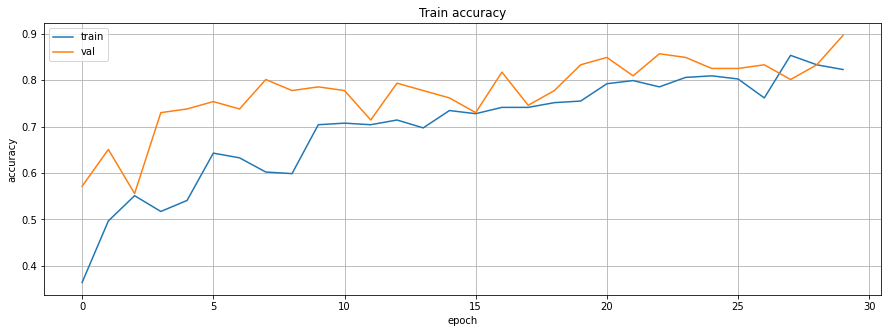

In [30]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

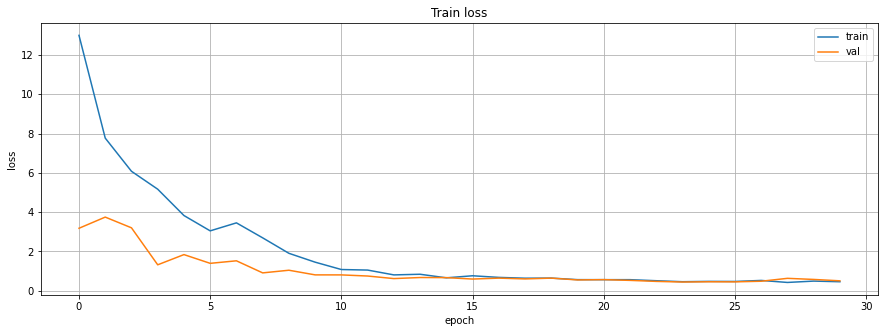

In [31]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

1/1 [==============================] - 0s 23ms/step


[Text(32.99999999999999, 0.5, 'Actual'), Text(0.5, 15.0, 'Predict')]

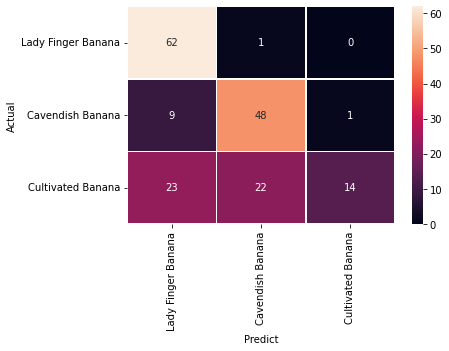

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = []
for i in range(len(x_test_rn)):
  x_input = x_test_rn[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

1/1 [==============================] - 0s 20ms/step


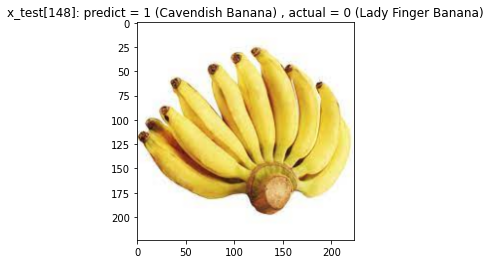

1/1 [==============================] - 0s 19ms/step


In [33]:
for i in range(len(x_test_rn)):
  y_pred = model.predict(x_test_rn[i].reshape(1,224,224,3))
  if np.argmax(y_pred) != y_test[i] and y_test[i]==0:
    plt.imshow(x_test[i])
    plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
    plt.show()
  else:
    continue

In [34]:
# for i in range(5):
#   y_pred = model.predict(x_test_xc[i].reshape(1,224,224,3))
#   plt.imshow(x_test[i])
#   plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
#   plt.show()

# **Grad-CAM**

1/1 [==============================] - 0s 20ms/step
Predicted: Cultivated Banana | Actual: Cultivated Banana 


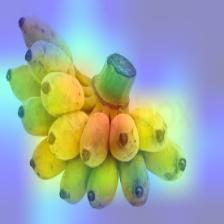

1/1 [==============================] - 0s 21ms/step
Predicted: Lady Finger Banana | Actual: Cultivated Banana 


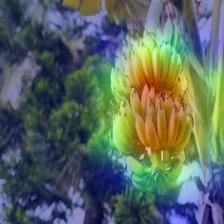

1/1 [==============================] - 0s 25ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


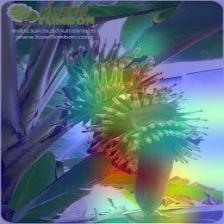

1/1 [==============================] - 0s 29ms/step
Predicted: Cavendish Banana | Actual: Cavendish Banana 


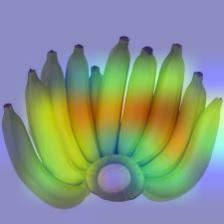

1/1 [==============================] - 0s 21ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


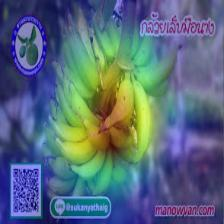

In [35]:
preprocess_input = keras.applications.resnet_v2.preprocess_input
last_conv_layer_name = "conv5_block3_3_conv"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)